$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge simulate$ $\hspace{0.1cm}$ $\Huge tSZ$ $\hspace{0.1cm}$ $\Huge maps$ $\hspace{0.1cm}$ $\Huge at$ $\hspace{0.1cm}$ $\Huge differents$ $\hspace{0.1cm}$ $\Huge frequencies$ $\hspace{0.1cm}$ $\Huge from$ $\hspace{0.1cm}$ $\Huge a$ $\hspace{0.1cm}$ $\Huge Compton-y$ $\hspace{0.1cm}$ $\Huge map$ $\Huge :$ 

# TO DO : 

# Modules : 

In [1]:
import healpy as hp
import matplotlib.pyplot as plt 
from astropy import constants as cst
import numpy as np
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from astropy.io import fits
from astropy import units as u

# Physics : 

In [2]:
T_CMB = 2.726 #CMB temperature in K

# Functions : 

## tSZ spectrum : 

###### Computation of tSZ spetrum and the mixing vector  for Intensity maps : 

We want to diplay the tSZ spectral shape by computing the intensity difference it generates, we have : 

$\Delta I_{tSZ}=I_{0}yf(x(\nu))h(x(\nu))=I_{0}y\frac{x(\nu)^{4}e ^{x(\nu)}}{(e^{x(\nu)}-1)^{2}}(x(\nu)\frac{e^{x(\nu)}+1}{e^{x(\nu)}-1}-4)$    with $x(\nu)=\frac{h\nu}{k_{B}T_{CMB}}$ and $y=\frac{\sigma _{T}}{m_{e}c^{2}}\int P_{e}dl$ where $P_{e}=n_{e}k_{B}T_{e}$

In [3]:
def D_I_tSZ(x,y):
    
    """
    Function which compute the tSZ spectral shape. 

    Parameters
    ----------
    
    x : array
        Frequency range over which the tSZ spectral shape will be computed. 
    y : float
        Value of the Compton-y parameter assumed here. 
        
    Returns
    -------
    array
        Array contaning the Variarion of intensity produced by tSZ over the fequencies. 

    """
    
    #Compute Delta I : 
    I_0 = (2*(cst.k_B.value*T_CMB)**3)/(cst.h.value*cst.c.value)**2    
    x_nu = np.array((cst.h.value*x)/(cst.k_B.value*T_CMB))    
    Delta_I = np.array(I_0*y*(x_nu**4)*(np.exp(x_nu)/(np.exp(x_nu)-1)**2)*((x_nu*(np.exp(x_nu)+1)/(np.exp(x_nu)-1))-4))
    
    #Give feedback to the operator : 
    print("Delta I as been computed ")
    
    return   Delta_I

Then, we want to compute the mixing vector. That is to say, the multiplicating factor that transform the comptyon-y map into a tSZ map at a given frequency. Here we also need to specify the value of y. 

In [4]:
def mixing_vector(dic_freq): 
    
    """
    Function which compute the multiplying vector to transform a y-map into a tSZ(f). 

    Parameters
    ----------
    
    dic_freq : dic
        Dictonary containing the frequencies we want to get a tSZ map of. 
        
    Returns
    -------
    array
        Array contaning the multiplying vector. 

    """    
    
    #Initilisation : 
    freq = np.arange(0,1000)*10**9  
    mix_vect = []
    
    # Compute the spectral shape of tSZ : 
    Delta_I = D_I_tSZ(freq,1)

    #For each frequency channel, compute Delta_I : 
    for i in range(len(dic_freq)):
        mix_vect.append(Delta_I[dic_freq[i]]*(10**20))
        
    #Give feeback to the operator :    
    print('The mixing vector is : ',mix_vect)
    
    #Display the spectral shape of tSZ  : 
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.ylabel('$\Delta I (MJysr^{-1})$',fontsize=28)
    plt.xlabel('$Frequency$ $(GHz)$',fontsize=28)
    plt.title('')
    plt.hlines(y=0.,xmin=0,xmax=10000, colors='k', linestyles='solid') 
    plt.plot(freq,np.array(Delta_I)*10**20)
    plt.show()

    return mix_vect

## Multiply a map by a given vector : 

Now that we have the mixing vector for the frequencies used in our data, we can multiply the compton-y map by this vector, which will give us the map of tSZ at each frequency. 

In [5]:
def modify_map(file_in,multiplier,data_origin,map_unit,pictures_path,dic_freq,factor,name_object,freq_unit,data_path,
              multiply,unit_out,fits,data_save,pf_1): 

    """
    Function which take a Healpix map and multiply it by a given vector. 

    Parameters
    ----------
    file_in : Healpy map
        Healpy map containing for exemple the compton-y map. 
    multiplier : array
        Array containing the different values you want to multiply the map with.
    data_origin : str
        Origin of the data used here, for exemple Planck AllSky maps. 
        This is going to be use for figures titles and names of files. 
    maps_unit : str 
        Units of the maps that are displayed, for exemple K_CMB, MJy/sr. 
        This is going to be use for figure titles and names of files.      
    pictures_path : str
        Path where we are going to save the pictures.
    dic_freq : dict
        Dictonary containing all the frequencies we want to deal with for those peculiar data.     
    factor : float 
        Factor we want to multiply the data with, can be used to convert units from for exemple MJ/sr to J/sr.
    name_object : str
        Type of Healpix map. FOR EXEMPLE : CMB, tSZ, kSZ.    
        This is going to be use for figure titles and names of files.  
    freq_unit : str
        Units of the frequencies, for exemple GHz. This is going to be use for figure titles and names of files.         
    data_path : str
        Path were the data of the maps are stored.     
    multiply : bool 
        If True the we multiply the compton-y by the tSZ spectra. If False, we divide multiples maps by the tSZ 
        spectra.
    unit_out : str
        Name of the final unit of the map. 
    fits : bool
        If True mean that the file getting in is a fits file. 
    data_save : str
        Path under which the data will be saved. 
    pf_1 : str
        First part of the name of the file getting in. 
        
    Returns
    -------
    None

    """
    
    #Multiply the map by the mixing vector : 
    if multiply == True: 
        
        if fits == True: 
            
            #Open file to be multiplied by the mixing vector : 
            file = data_path + file_in 
            maps = hp.read_map(file)
            file_in = np.array(maps, dtype = np.float32)           
            maps_freq = (file_in * multiplier) * factor
            
            #Operator feedback : 
            print(name_object + ' map at the frequency ' + str(dic_freq) + freq_unit + ' :')
        
            #Diplay the tSZ map at the fequency : 
            hp.mollview(map=maps_freq, coord=None, nest=False,
                        title='tSZ maps ' + str(dic_freq) + 'GHz from ' + data_origin, unit=map_unit,
                        norm='hist',xsize=2000,return_projected_map=True) #Display a read FITS file with Healpy and save it
            plt.savefig(pictures_path + name_object + '_' + str(dic_freq) + freq_unit + '_' + data_origin + '.png') #Save the figure        
            plt.show()   
        
            #Save file : 
            hp.write_map(data_save + 'tSZ_' + str(dic_freq) + freq_unit + '_' + unit_out + '_' + data_origin + '.fits', maps_freq,
                         nest=False,dtype=np.float32,overwrite=True)
        
            #Operator feedback : 
            print('Maps is saved under the name : ' + data_save + 'tSZ_' + str(dic_freq) + freq_unit + '_' + unit_out + '_'+ data_origin+ '.fits')        

        if fits == False:
        
            file_in = file_in
            
            for i in range(0,len(multiplier)): #Goes over the vector, to multiply the map by all of its values.
                
                #For each frequency, multiply by the appropriate coeff : 
                maps_freq = (file_in * multiplier[i]) * factor

                #Operator feedback : 
                print(name_object + ' map at the frequency ' + str(dic_freq[i]) + freq_unit + ' :')
        
                #Diplay the tSZ map at the fequency : 
                hp.mollview(map=maps_freq, coord=None, nest=False,
                            title='tSZ maps ' + str(dic_freq[i]) + 'GHz from ' + data_origin, unit=map_unit,
                            norm='hist',xsize=2000,return_projected_map=True) #Display a read FITS file with Healpy and save it
                plt.savefig(pictures_path + name_object + '_' + str(dic_freq[i]) + freq_unit + '_' + data_origin + '.png') #Save the figure        
                plt.show()   
        
        
                #Save file : 
                hp.fitsfunc.write_map(data_save + 'tSZ_' + str(dic_freq[i]) + freq_unit + '_' + unit_out + '_' + data_origin + '.fits', maps_freq,
                             nest=False,dtype=np.float32,overwrite=True)
        
                #Operator feedback : 
                print('Maps is saved under the name : ' + data_save + 'tSZ_' + str(dic_freq[i]) + freq_unit + '_' + unit_out + '_'+ data_origin+ '.fits')
       
    #In case we want to divide the maps by the mixing vector factor : 
    if multiply == False:
        
        for i in range(len(dic_freq)): #Goes over the vector, to multiply the map by all of its values.
        
            if dic_freq[i] < 100:
                # Read the datas :
                file = data_path + '0' + str(dic_freq[i]) + file_in 
            else:
                file = data_path + pf_1 + str(dic_freq[i]) + file_in
                print(file)
    
            # Open the datas :    
            maps = hp.read_map(file)
            map_f = np.array(maps, dtype = np.float32)
            
            #Muttiply the datas by the mixing vector : 
            maps_freq = map_f / (multiplier[i] * factor)

            print(name_object + ' map at the frequency ' + str(dic_freq[i]) + freq_unit + ' :')
            hp.mollview(map=maps_freq, coord=None, nest=False,title='Compton-y from ' + data_origin, unit=map_unit, 
                    norm='hist',xsize=2000,return_projected_map=True) #Display a read FITS file with Healpy and save it
            plt.savefig(pictures_path + 'Compton-y_' + data_origin + '.png') #Save the figure        
            plt.show()   
        
        
            #Save file : 
            hp.write_map(data_save + 'Compton-y_' + data_origin + '.fits', maps_freq,nest=False,dtype=np.float32,
                     overwrite=True)
            print('Maps is saved under the name : ' + data_save + 'Compton-y_' + data_origin + '.fits')
          

    print("Map has been multiplied by the mixing vector, Images are saved in " + pictures_path)

        
    return maps_freq

## Convert Jy/sr to K : 

##### Thermal SZ from Sehgal(2010) : 

The equation to convert between a change in intensity ($\Delta I$) and a change of Temperature ($\Delta T_{CMB}$) is : 

$\frac{\Delta I}{\Delta T_{CMB}}=\frac{I_0}{T_{CMB}}\frac{x^{4}e^{x}}{(e^{x}-1)^{2}}$ 

Then to go from a map in Jysr$^{-1}$ to a map in $\mu K$ we need to multiply the maps by the INVERSE of : 

$\Delta T_{CMB} = \frac{T_{CMB}\times 10^{6}\Delta I}{I_0\times 10^{26}}\frac{(e^{x}-1)^{2}}{x^{4}e^{x}}$

$I_0\times 10^{20}=270.33$ is converted from [MJy/sr] to [Jy/sr] by multiplying by $10^{6}$. To get the maps in $\mu K$, we multiply $T_{CMB}$ [K] by $10^{6}$ also. 

In [6]:
def DT_kSZ(x,y):

    """
    Code which compute the function to change units from Jy/sr to mK.   

    Parameters
    ----------
    
    x : str
        Path were the data of the maps are stored and we the cutout are going to be stored. 
    y : str
        Name of the data file. 
        
    Returns
    -------
    str
        Return the conversion function.  

    """
    
    I_0 = 2*(cst.k_B.value*T_CMB)**3/(cst.h.value*cst.c.value)**2*1e26
    x_nu = (cst.h.value*x)/(cst.k_B.value*T_CMB)
    Delta_T = ((np.exp(x_nu)-1)**2)/(I_0*x_nu**4*np.exp(x_nu))
    
    print("Delta I as been computed ")
    
    return   Delta_T

In [7]:
def conv_vector(dic_freq): 
    
    """
    Function which compute the coefficient to convert Jy/sr map into mK.  

    Parameters
    ----------
    
    dic_freq : dictonary 
        Dictonary containing the frequencies which we want to be converted.   
        
    Returns
    -------
    str
        Tell us where the function stored the datas and images.

    """
        
    freq = np.arange(0,1000)*10**9  
    Delta_T = DT_kSZ(freq,1)
    conv_vect = []
    
    for i in range(0,len(dic_freq)):
        conv_vect.append(1/Delta_T[dic_freq[i]])
    print('The convertion vector is : ',conv_vect)

    return conv_vect

###### Thermal SZ from Simons Observatory simulations :

This map is in units of Compton-y (dimensionless), and was rescaled by a factor to bring the amplitude of the power spectrum into reasonable agreement with the Planck 2013 y-map tSZ power spectrum. To get this map in each frequency we need to multiply by the tSZ spectral function and by $T_{CMB}=2,726\times 10^{6}$ to get $\mu K$. 

Here the map we are getting after multiplying by the tSZ spectral function is in MJysr$^{-1}$, we need to convert it in Kelvins first before multiplying it with $T_{CMB}=2,726K$ 

## Tansform compton-y into tSZ at different frequencies :

In [8]:
def simulate_tSZ(simu,dic_freq,unit_out,rescale):
    
    #For datas where the compton-y map is provided : 
    
    if simu == 'SO':
        
        #Fixed datas : 
        data_path='/vol/arc3/data1/sz/SO_sky_model/CMB_SZ_maps/'
        data_save = '/vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/'
        pictures_path = '/vol/arc3/data1/sz/SO_sky_model/pictures/'
        file_in = data_path + 'tSZ_skymap_healpix_nopell_Nside4096_y_tSZrescale0p75.fits'
        
    if simu == 'CITA': 
        
        #Fixed datas :         
        data_path='/vol/arc3/data1/sz/CITA/'
        data_save = '/vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/CITA/'
        pictures_path = '/vol/arc3/data1/sz/CITA/pictures/'
        file_in = '/vol/arc3/data1/sz/CITA/tsz.fits'
        
    name_object = 'tSZ'
    freq_unit='GHz'   
        
    if simu == 'SO' or simu =='CITA':
            
        # Open, display and save the compton-y map : 
        tSZ_map = hp.read_map(file_in,nest=False,partial=False) #Read a FITS file with Healpy
        
        #Normalize by the rescaling factor :
        if simu=='SO' and rescale == 'True':
            
            factor = 0.75 #Factor used to bring Sehgal(2010) values of tSZ in agrrement with Planck,ACT,SPT
            tSZ_map = tSZ_map / factor
            print('rescaling factor removed from the maps')
            
        print('Here is the compton-y map from '+ simu + ' :')
        hp.mollview(map=tSZ_map, coord=None, nest=False,title='$tSZ$ $map$ $from$ '+ simu, unit='$Dimensionless$',
                    norm='hist', xsize=2000,return_projected_map=True) #Display a read FITS file with Healpy and save it
        plt.savefig(pictures_path + 'tSZ_'+simu+'.png')
        plt.show()
        
        
        #Computes the mixing vector : 
        multiplier = mixing_vector(dic_freq)
        
        #Muliply the data by the mixing vector : 
        
        if unit_out == 'Jysr':
            
            modify_map(file_in=tSZ_map,multiplier=multiplier,data_origin=simu,map_unit='Jysr$^{-1}$',
                        pictures_path=pictures_path,dic_freq=dic_freq,factor=10**6,name_object=name_object,
                        freq_unit=freq_unit,data_path=data_path, multiply=True,unit_out=unit_out,fits=False,
                        data_save=data_save,pf_1='')
        
        if unit_out == 'MJysr':

            modify_map(file_in=tSZ_map,multiplier=multiplier,data_origin=simu,map_unit='MJysr$^{-1}$',
                        pictures_path=pictures_path,dic_freq=dic_freq,factor=1.,name_object=name_object,
                        freq_unit=freq_unit,data_path=data_path, multiply=True,unit_out=unit_out,fits=False,
                        data_save=data_save,pf_='')
            
        if unit_out == 'mK':
            
            #First convert the compton-y into Jy/sr at different frequencies
            map_freq = modify_map(file_in=tSZ_map,multiplier=multiplier,data_origin=simu,map_unit='$Jysr^{-1}$',
                                    pictures_path=pictures_path,dic_freq=dic_freq,factor=10**6,name_object=name_object,
                                    freq_unit=freq_unit,data_path=data_path, multiply=True,unit_out=unit_out,fits=False,
                                    data_save=data_save,pf_1='') 
        
            #Convert the Jy/sr into mK at different frequencies 
            conv = conv_vector(dic_freq)
            a = np.ones(len(conv),dtype=float)
            final_conv = a/conv
            
            for i in range(0,len(dic_freq)):             
                
                modify_map(file_in='tSZ_'+str(dic_freq[i])+'GHz_mK_'+simu+'.fits',multiplier=final_conv[i],
                            data_origin=simu,map_unit='$\mu K$',pictures_path=pictures_path,dic_freq=dic_freq[i],
                            factor=T_CMB*10**6,name_object=name_object,freq_unit=freq_unit,data_path=data_save,
                            multiply=True,unit_out=unit_out,fits=True,data_save=data_save,pf_1='') 
    
    
    #For the datas where the compton-y map as to be computed first : 
    
    if simu == 'Sehgal': 
        
        #Fixed datas :         
        data_path='/vol/arc3/data1/sz/Sehgal/'
        data_save = '/vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/Sehgal/'
        pictures_path = '/vol/arc3/data1/sz/Sehgal/pictures/'
        name_object = 'compton-y'
        freq_unit='GHz'
        pf_1=''
        file_in='_tsz_healpix.fits'
        dic_short={0:30}
        

        
        #Computes the mixing vector : 
        multiplier = mixing_vector(dic_freq)
        
        #Create the compton-y map : 
        compton_y = modify_map(file_in=file_in,multiplier=multiplier,data_origin=simu,
                               map_unit='Dimensionless',pictures_path=pictures_path,dic_freq=dic_short,factor=10**6,
                               name_object=name_object,freq_unit=freq_unit,data_path=data_path, multiply=False,
                               unit_out=unit_out,fits=False,data_save=data_save,pf_1=pf_1)
        
        #Muliply the data by the mixing vector :    
        if unit_out == 'Jysr':
            
            modify_map(file_in=compton_y,multiplier=multiplier,data_origin=simu,map_unit='$Jysr^{-1}$',
                       pictures_path=pictures_path,dic_freq=dic_freq,factor=10**6,name_object=name_object,
                       freq_unit=freq_unit,data_path=data_path, multiply=True,unit_out=unit_out,fits=False, 
                       data_save=data_save,pf_1=pf_1)
            
        if unit_out == 'MJysr':
        
            modify_map(file_in=compton_y,multiplier=multiplier,data_origin=simu,map_unit='$MJysr^{-1}$',
                        pictures_path=pictures_path,dic_freq=dic_freq,factor=1.,name_object=name_object,
                        freq_unit=freq_unit,data_path=data_path, multiply=True,unit_out=unit_out,fits=False,
                        data_save=data_save,pf_1=pf_1)
        
        if unit_out == 'mK':
            
            #First convert the compton-y into Jy/sr at different frequencies
            map_freq = modify_map(file_in=compton_y,multiplier=multiplier,data_origin=simu,map_unit='$Jysr^{-1}$',
                       pictures_path=pictures_path,dic_freq=dic_freq,factor=10**6,name_object=name_object,
                       freq_unit=freq_unit,data_path=data_path, multiply=True,unit_out=unit_out,fits=False, 
                       data_save=data_save,pf_1=pf_1)
            
            #Convert the Jy/sr into mK at different frequencies 
            conv = conv_vector(dic_freq)
            a = np.ones(len(conv),dtype=float)
            final_conv = a/conv
            
            for i in range(0,len(dic_freq)):              
                
                modify_map(file_in='tSZ_'+str(dic_freq[i])+'GHz_mK_Sehgal.fits',multiplier=final_conv[i],
                           data_origin=simu,map_unit='$\mu K$',pictures_path=pictures_path,dic_freq=dic_freq[i],
                           factor=T_CMB*10**6,name_object=name_object,freq_unit=freq_unit,data_path=data_save,
                           multiply=True,unit_out=unit_out,fits=True,data_save=data_save,pf_1=pf_1)
                     

# Launch :

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Here is the compton-y map from SO :


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


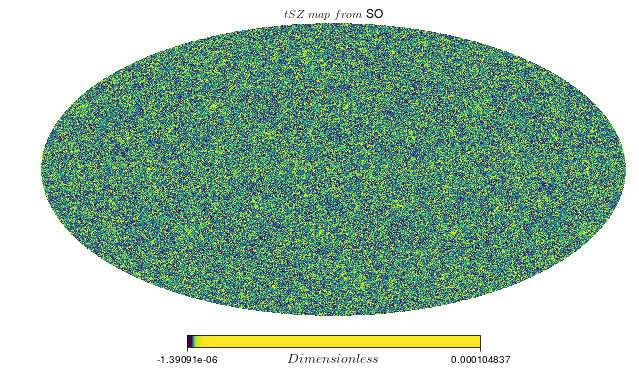

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Delta I as been computed 
The mixing vector is :  [-143.8899407654085, -883.1820500637076, -1049.737727252455, 29.40584136277238, 1125.6225289807296, 1804.4755243602515]


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


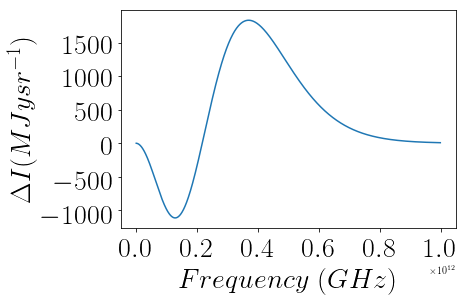

tSZ map at the frequency 30GHz :


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


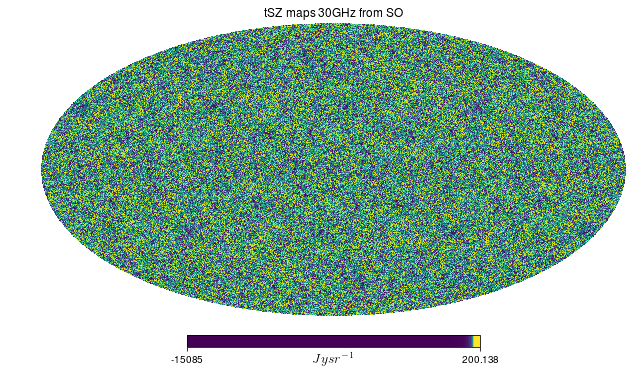

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_30GHz_mK_SO.fits
tSZ map at the frequency 90GHz :


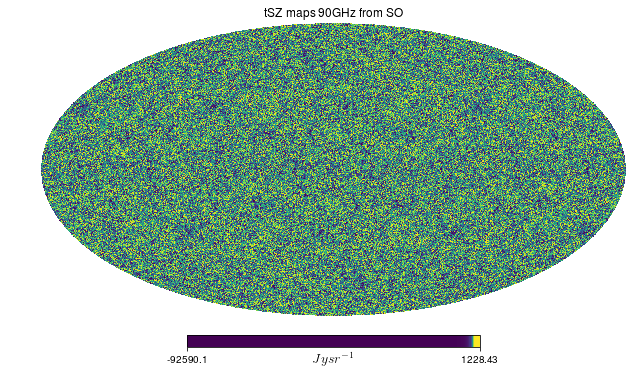

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_90GHz_mK_SO.fits
tSZ map at the frequency 148GHz :


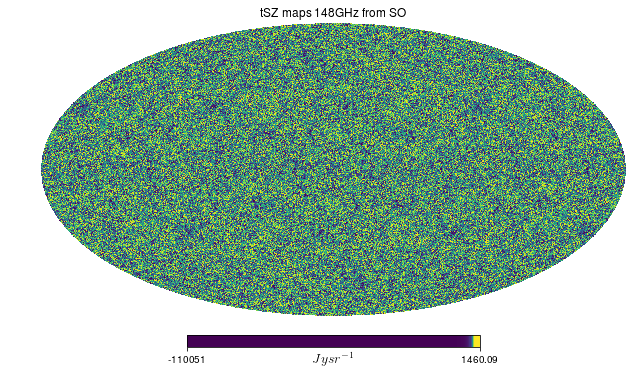

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_148GHz_mK_SO.fits
tSZ map at the frequency 219GHz :


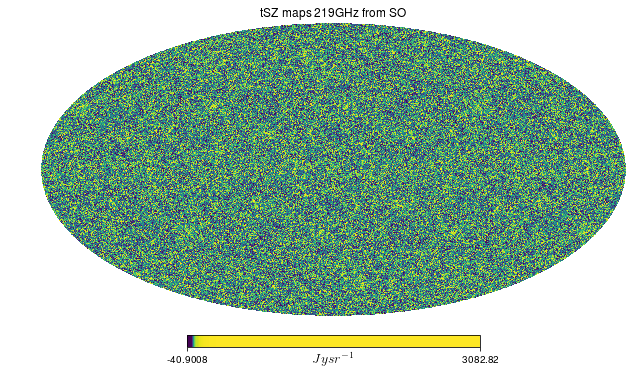

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_219GHz_mK_SO.fits
tSZ map at the frequency 277GHz :


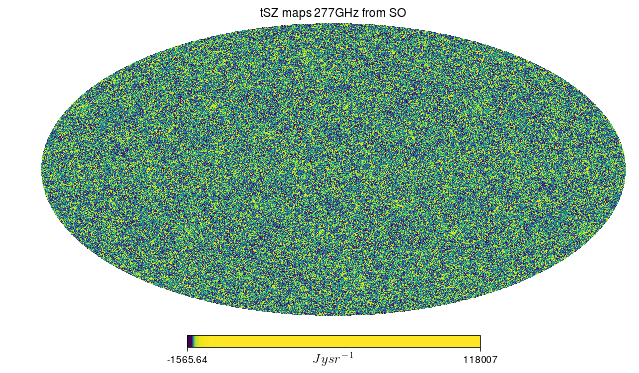

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_277GHz_mK_SO.fits
tSZ map at the frequency 350GHz :


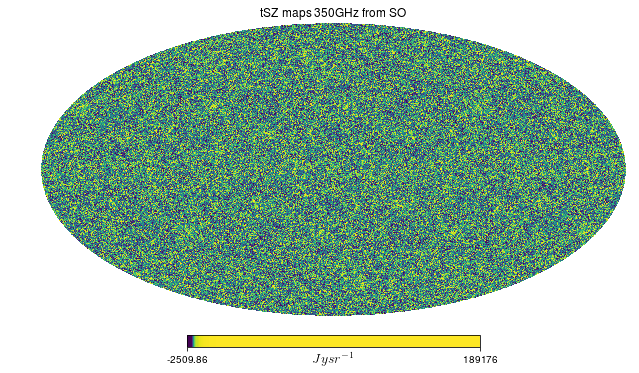

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_350GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/
Delta I as been computed 
The convertion vector is :  [73649138.87453118, 552648821.0813361, 1072465577.4152255, 1318812271.792511, 1182847831.1813076, 824736250.7142823]
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


tSZ map at the frequency 30GHz :


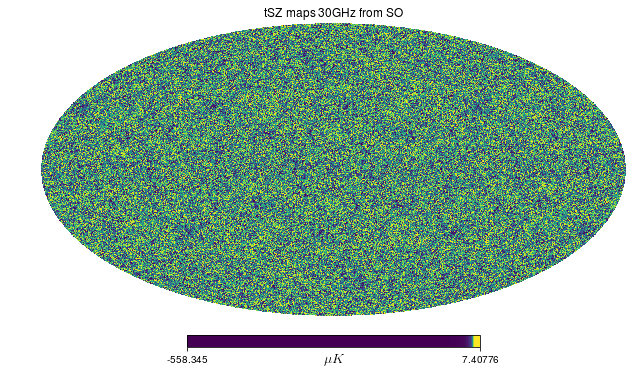

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_30GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ map at the frequency 90GHz :


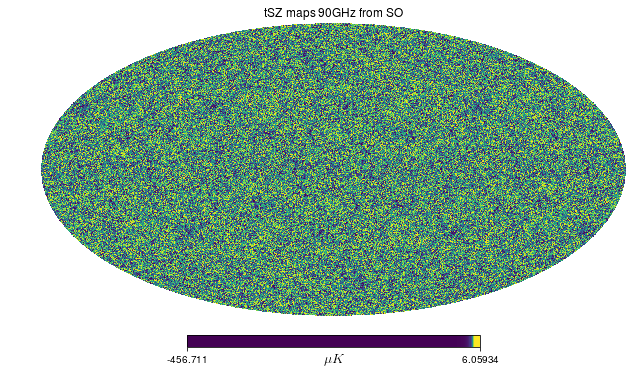

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_90GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ map at the frequency 148GHz :


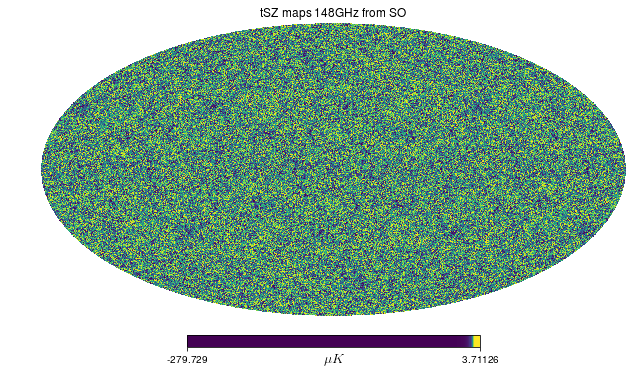

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_148GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ map at the frequency 219GHz :


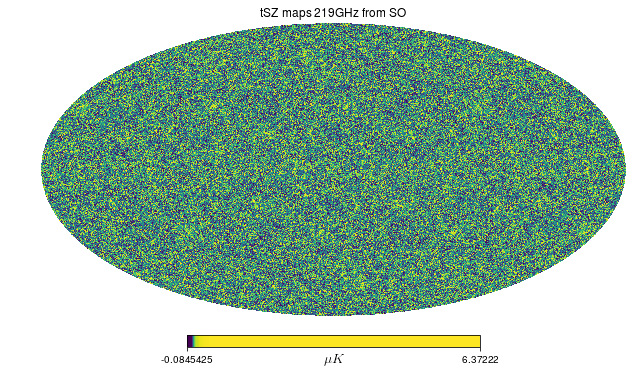

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_219GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ map at the frequency 277GHz :


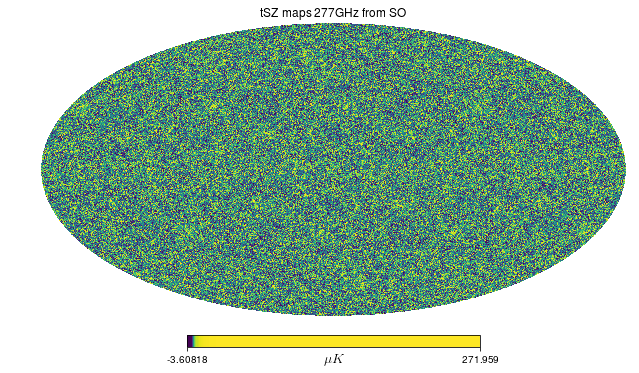

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_277GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ map at the frequency 350GHz :


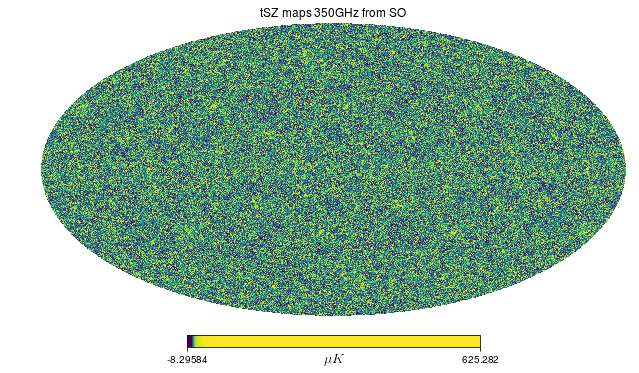

Maps is saved under the name : /vol/arc3/data1/sz/CCATp_sky_model/workspace_maude/SO/tSZ_350GHz_mK_SO.fits
Map has been multiplied by the mixing vector, Images are saved in /vol/arc3/data1/sz/SO_sky_model/pictures/


In [9]:
simulate_tSZ(simu='SO',dic_freq={0:30,1:90,2:148,3:219,4:277,5:350},unit_out='mK',rescale='False')